In [1]:
import tkinter as tk
from tkinter import filedialog,Toplevel
from PIL import Image, ImageTk, ImageDraw
import numpy as np
from skimage.draw import polygon
from dt_apriltags import Detector
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import CubicSpline

import torch
import copy

import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

at_detector = Detector(families='tag25h9',
                       nthreads=1,
                       quad_decimate=1.0,
                       quad_sigma=0.0,
                       refine_edges=1,
                       decode_sharpening=0.25,
                       debug=0)

/home/tomtang/anaconda3/envs/z1_arm/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/tomtang/anaconda3/envs/z1_arm/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
#Geometry Utils
def to_radians(degrees):
    return degrees * torch.pi / 180

def rotation_matrix(yaw, pitch, roll):
    # Convert angles to radians
    yaw, pitch, roll = to_radians(yaw), to_radians(pitch), to_radians(roll)

    # Yaw rotation matrix
    yaw_matrix = torch.tensor([
        [torch.cos(yaw), 0, torch.sin(yaw)],
        [0, 1, 0],
        [-torch.sin(yaw), 0, torch.cos(yaw)]
    ])

    # Pitch rotation matrix
    pitch_matrix = torch.tensor([
        [1, 0, 0],
        [0, torch.cos(pitch), -torch.sin(pitch)],
        [0, torch.sin(pitch), torch.cos(pitch)]
    ])

    # Roll rotation matrix
    roll_matrix = torch.tensor([
        [torch.cos(roll), -torch.sin(roll), 0],
        [torch.sin(roll), torch.cos(roll), 0],
        [0, 0, 1]
    ])

    # Combine the rotation matrices
    return yaw_matrix @ pitch_matrix @ roll_matrix

def rotate_vector(origin, yaw_pitch_roll):
    yaw=yaw_pitch_roll[0]
    pitch=yaw_pitch_roll[1]
    roll=yaw_pitch_roll[2]
    rot_mat = rotation_matrix(yaw, pitch, roll)
    unit_x = torch.tensor([1., 0., 0.])
    unit_z = torch.tensor([0., 0., 1.])

    # Rotate unit vectors
    rotated_x = rot_mat @ unit_x
    rotated_z = rot_mat @ unit_z

    # Normalize the vectors
    rotated_x = rotated_x / (10*torch.norm(rotated_x))
    rotated_z = rotated_z / (10*torch.norm(rotated_z))

    # Translate the vectors
    final_x = origin + rotated_x
    final_z = origin + rotated_z

    return final_x, final_z
    
def get_rot_t(file_str,t_grid_3d):
    img = cv2.imread(file_str, cv2.IMREAD_GRAYSCALE)
    tags = at_detector.detect(img, estimate_tag_pose=True,
                              camera_params=camera_params_c,
                              tag_size=0.05)
    tags_cent_list=[]
    for i in range(len(tags)):
        tags_cent_list.append(tags[i].center)
    tags_cent_np=np.vstack(tags_cent_list)
    success, vector_rotation, vector_translation = cv2.solvePnP(t_grid_3d,
                                                                tags_cent_np,
                                                                mtx, distortion_coeffs)
    R,_=cv2.Rodrigues(vector_rotation)
    return (R,vector_translation,vector_rotation)

def project_image_points_to_world_torch(img_points, mtx_s, R, T):
    world_points = []
    inv_camera_matrix = torch.linalg.inv(mtx_s)
    inv_rotation_matrix = torch.linalg.inv(R)
    for img_point in img_points:
        normalized_point = torch.matmul(inv_camera_matrix, img_point)
        point_camera = torch.tensor([normalized_point[0], normalized_point[1], 1])
        point_world = torch.matmul(inv_rotation_matrix, point_camera-T.view(-1))
        world_points.append(point_world.reshape((-1,3)))
    return torch.vstack(world_points)

def get_ray_samples(origin, targets, length, num_samples):
    directions = targets - origin
    directions = directions / torch.norm(directions, dim=1, keepdim=True)
    samples = torch.linspace(0.1, length, num_samples)  # [num_samples]
    origin = origin.unsqueeze(0).unsqueeze(0)  # [1, 1, 3]
    directions = directions.unsqueeze(1)  # [n, 1, 3]
    samples = samples.unsqueeze(0).unsqueeze(2)  # [1, num_samples, 1]
    ray_samples = origin + samples * directions  # [n, num_samples, 3]
    return ray_samples

In [3]:
dist_g=0.065
width_s=3.
height_s=4.
width_np=np.arange(0,width_s)
height_np=np.arange(0,height_s)
w, h = np.meshgrid(width_np, height_np, indexing='ij')
grid=np.concatenate([w[:,:,None],h[:,:,None]],2).reshape((-1,2))
t_grid=copy.copy(grid)
t_grid[:,0]=((grid[:,0]+0.5)-0.5*width_s)*dist_g
t_grid[:,1]=((grid[:,1]+0.5)-0.5*height_s)*dist_g
t_grid_3d=np.concatenate([t_grid,np.zeros((len(t_grid),1))],axis=1)
focal_length = 3400
img_size=(3008,2000)
center = (img_size[0]/2, img_size[1]/2)
mtx=np.array([[focal_length, 0, center[0]],
             [0, focal_length, center[1]],
             [0, 0, 1]], dtype = "double")
distortion_coeffs = np.array([])
camera_params_c=[focal_length,focal_length,1504,1000]
resize_shape=(100,100)
resize_transform = transforms.Resize(resize_shape)
mtx_s=np.array([[focal_length/(img_size[0]/resize_shape[0]), 0, resize_shape[0]/2],
             [0, focal_length/(img_size[1]/resize_shape[1]), resize_shape[1]/2],
             [0, 0, 1]], dtype = "double")
grid_2d=torch.tensor(np.indices(resize_shape).reshape(2, -1).T)
grid_2d_w=torch.cat([grid_2d,torch.ones((len(grid_2d),1))],dim=1).double()

#globals##############
image_path1 = None
image_path2 = None

arrow_ids = {}
orientation_values = {}
current_cluster_id = 0

region1 = None
region2 = None
inter_points_list=[]
mean_inter_p_list=[]
first_scatter_r=None
second_scatter_r=None
current_val_scatter=0

Rs = None
Ts = None
Vs = None

red_line_ids_canvas1 = []
red_line_ids_canvas2 = []

#######################

#UI utils#############
def load_image(canvas, image_number):
    global image_path1, image_path2
    file_path = filedialog.askopenfilename()
    if file_path:
        if image_number == 1:
            image_path1 = file_path
        else:
            image_path2 = file_path
        image = Image.open(file_path)
        image = image.resize((600, 400))  # Resize the image to 1200x800
        photo = ImageTk.PhotoImage(image)
        canvas.image = image  # Keep a reference to the image
        canvas.photo = photo  # Keep a reference to the Tkinter PhotoImage
        canvas.config(width=600, height=400)
        canvas.create_image(0, 0, image=photo, anchor='nw')
        status_label.config(text=f"Image {image_number} loaded")

def start_line(event, canvas):
    canvas.coords = [(event.x, event.y)]
    canvas.bind("<B1-Motion>", lambda e: on_drag(e, canvas))

def on_drag(event, canvas):
    x, y = event.x, event.y
    canvas.coords.append((x, y))
    line_id = canvas.create_oval(canvas.coords[-2], canvas.coords[-1],fill='red', outline='red', width=1)
    if canvas == canvas1:
        red_line_ids_canvas1.append(line_id)
    elif canvas == canvas2:
        red_line_ids_canvas2.append(line_id)

def on_release(event, canvas):
    canvas.unbind("<B1-Motion>")
    # Close the curve if it is not closed
    if canvas.coords[0] != canvas.coords[-1]:
        canvas.coords.append(canvas.coords[0])
    line_id = canvas.create_oval(canvas.coords[-2], canvas.coords[-1], fill='red', outline='red', width=1)
    if canvas == canvas1:
        red_line_ids_canvas1.append(line_id)
    elif canvas == canvas2:
        red_line_ids_canvas2.append(line_id)

def start_drawing(canvas):
    canvas.bind("<Button-1>", lambda e: start_line(e, canvas))
    canvas.bind("<ButtonRelease-1>", lambda e: on_release(e, canvas))

def add_region():
    start_drawing(canvas1)
    start_drawing(canvas2)

def compute_region(canvas):
    if not hasattr(canvas, 'coords'):
        return None

    # Assuming the canvas and the image are the same size
    img_shape = (canvas.winfo_height(), canvas.winfo_width())
    mask = np.zeros(img_shape, dtype=np.uint8)

    # Extract x and y coordinates
    x, y = zip(*canvas.coords)
    rr, cc = polygon(y, x)  # skimage's polygon function to get pixels within the polygon
    mask[rr, cc] = 1

    return mask

def bind_drawing(canvas):
    """ Bind drawing events to the canvas. """
    canvas.bind("<Button-1>", lambda e: start_line(e, canvas))
    canvas.bind("<ButtonRelease-1>", lambda e: on_release(e, canvas))

def unbind_drawing(canvas):
    """ Unbind drawing events from the canvas. """
    canvas.unbind("<Button-1>")
    canvas.unbind("<ButtonRelease-1>")

def add_region():
    """ Enable drawing on both canvases. """
    bind_drawing(canvas1)
    bind_drawing(canvas2)
    status_label.config(text="Draw regions on both images")

def compute_both_regions():
    global region1, region2
    region1 = compute_region(canvas1)
    region2 = compute_region(canvas2)
    plot_and_clear()
    unbind_drawing(canvas1)
    unbind_drawing(canvas2)
    status_label.config(text="Regions computed")

def clear_canvas(canvas):
    canvas.delete("all")
    if canvas.photo:  # Redraw the image if it exists
        canvas.create_image(0, 0, image=canvas.photo, anchor='nw')

def clear_red_lines(canvas, red_line_ids):
    # Remove all red lines from the canvas
    for line_id in red_line_ids:
        canvas.delete(line_id)
    # Clear the list after removing the lines
    red_line_ids.clear()

def scatter_plot_points(canvas, points,size=1,colour='blue'):
    global current_cluster_id
    # Increment cluster ID
    cluster_id = current_cluster_id

    # Initialize the cluster entry
    arrow_ids[cluster_id] = {'canvas1': [], 'canvas2': []}

    for point in points:
        x, y = point
        scatter_id = canvas.create_oval(x-size, y-size, x+size, y+size, fill=colour, outline=colour)
        canvas.tag_bind(scatter_id, '<Button-1>', lambda e, cid=cluster_id: on_scatter_point_click(e, cid))
    #current_cluster_id += 1

def clear_canvas(canvas):
    canvas.delete("all")
    if canvas.photo:  # Redraw the image if it exists
        canvas.create_image(0, 0, image=canvas.photo, anchor='nw')

def draw_arrow(canvas, cluster_id, start_point, end_point, arrow_color='red',arrow_thickness=8):
    start_x, start_y = start_point
    end_x, end_y = end_point
    canvas_name = 'canvas1' if canvas == canvas1 else 'canvas2'
    # Draw an arrow from start_point to end_point
    arrow_id = canvas.create_line(start_x, start_y, end_x, end_y, arrow=tk.LAST, fill=arrow_color,width=arrow_thickness)
    # Store the arrow ID
    arrow_ids[cluster_id][canvas_name].append((arrow_id, True))

def toggle_arrows(cluster_id, visible):
    """ Toggle the visibility of arrows for a specific cluster. """
    if cluster_id in arrow_ids:
        for canvas_name, arrows in arrow_ids[cluster_id].items():
            canvas = canvas1 if canvas_name == 'canvas1' else canvas2
            for arrow_id, _ in arrows:
                canvas.itemconfig(arrow_id, state='normal' if visible else 'hidden')
            arrow_ids[cluster_id][canvas_name] = [(aid, visible) for aid, _ in arrows]

def del_arrows(cluster_id):
    if cluster_id in arrow_ids:
        for canvas_name, arrows in arrow_ids[cluster_id].items():
            canvas = canvas1 if canvas_name == 'canvas1' else canvas2
            for arrow_id, _ in arrows:
                canvas.delete(arrow_id)
        #re-init dict
        arrow_ids[cluster_id] = {'canvas1': [], 'canvas2': []}
        

def on_constrain_toggle(checkbutton,cluster_id):
    """ Handle the toggle of the check_constrain checkbox. """
    check_var = checkbutton.cget('variable')
    visible = check_var.get() == 1
    toggle_arrows(cluster_id, visible)

def toggle_arrows_visibility(cluster_id):
    """ Toggle the visibility of arrows for the given cluster. """
    if cluster_id in arrow_ids:
        # Determine if any arrow in the cluster is currently visible
        currently_visible = any(visibility for _, visibility in arrow_ids[cluster_id]['canvas1'])

        # Toggle visibility
        new_visibility = not currently_visible
        toggle_arrows(cluster_id, new_visibility)

        # Update arrow visibility state
        for canvas_name in arrow_ids[cluster_id]:
            arrow_ids[cluster_id][canvas_name] = [(arrow_id, new_visibility) for arrow_id, _ in arrow_ids[cluster_id][canvas_name]]


def create_orientation_window(cluster_id):
    global orientation_values
    orientation_window = Toplevel(root)
    orientation_window.title("Orientation Settings")

    toggle_button = tk.Button(orientation_window, text="Toggle Arrows", command=lambda: toggle_arrows_visibility(cluster_id))
    toggle_button.pack()
    
    # Check if there are saved values for this cluster
    saved_values = orientation_values.get(cluster_id, {'yaw': 0, 'pitch': 0, 'roll': 0})

    # Yaw Scale
    yaw_scale = tk.Scale(orientation_window, from_=-180, to=180, orient='horizontal', label="Yaw")
    yaw_scale.set(saved_values['yaw'])  # Initialize with saved value
    yaw_scale.pack()

    # Pitch Scale
    pitch_scale = tk.Scale(orientation_window, from_=-90, to=90, orient='horizontal', label="Pitch")
    pitch_scale.set(saved_values['pitch'])  # Initialize with saved value
    pitch_scale.pack()

    # Roll Scale
    roll_scale = tk.Scale(orientation_window, from_=-180, to=180, orient='horizontal', label="Roll")
    roll_scale.set(saved_values['roll'])  # Initialize with saved value
    roll_scale.pack()

    # Function to update values in the dictionary
    def update_orientation_values():
        orientation_values[cluster_id] = {
            'yaw': yaw_scale.get(),
            'pitch': pitch_scale.get(),
            'roll': roll_scale.get()
        }
        cluster_mean=mean_inter_p_list[cluster_id]
        ypr=torch.tensor([yaw_scale.get(),pitch_scale.get(),roll_scale.get()])
        
        del_arrows(cluster_id)
        draw_arrows(cluster_mean, ypr, Vs, Ts, [canvas1, canvas2],cluster_id)
        #recompute arrow end in 3d
        

    # Button to get and save values
    get_values_button = tk.Button(orientation_window, text="Get and Save Values", command=update_orientation_values)
    get_values_button.pack()

def get_orientation_values(yaw_scale, pitch_scale, roll_scale):
    """ Function to retrieve values from orientation widgets. """
    #remove_arrows()
    print(f"Yaw: {yaw_scale.get()}, Pitch: {pitch_scale.get()}, Roll: {roll_scale.get()}")

def on_scatter_point_click(event,cluster_id):
    print(f"Cluster {cluster_id} clicked")
    create_orientation_window(cluster_id)

# Define smaller sub-functions for specific tasks

def clear_canvases():
    clear_red_lines(canvas1, red_line_ids_canvas1)
    clear_red_lines(canvas2, red_line_ids_canvas2)

def get_camera_positions(Rs, Ts):
    return [-np.dot(R.T, T) for R, T in zip(Rs, Ts)]

def prepare_regions_for_processing(regions):
    return [resize_transform(torch.tensor(region).float().unsqueeze(0).unsqueeze(0)).reshape((100, 100)) for region in regions]

def calculate_world_space_points(view_grids, camera_matrix, rotation_matrices, translation_vectors, camera_positions, ray_length, sample_points):
    world_space_points = []
    for v_grid, R, T, camera_position in zip(view_grids, rotation_matrices, translation_vectors, camera_positions):
        world_points = project_image_points_to_world_torch(v_grid[::2], camera_matrix, R, T)
        sampled_points = get_ray_samples(camera_position.reshape(-1), world_points, ray_length, sample_points)
        reshaped_points = sampled_points.reshape((-1, 3))
        world_space_points.append(reshaped_points)
    return world_space_points
    
def project_and_draw_points(inter_points, Vs, Ts, canvases):
    for V, T, canvas in zip(Vs, Ts, canvases):
        scatter, _ = cv2.projectPoints(np.array(inter_points.detach().cpu()), V, T, mtx, distortion_coeffs)
        scatter_r = (scatter / 5)[:, 0]
        scatter_plot_points(canvas, scatter_r)

def draw_arrows(mean_inter_p, ypr,Vs, Ts, canvases,over_ride_id=None):
    x_a, z_a = rotate_vector(mean_inter_p, ypr)
    if over_ride_id==None:
        over_ride_id=current_cluster_id
    all_points = torch.cat([mean_inter_p[None], x_a[None], z_a[None]], dim=0)

    for V, T, canvas in zip(Vs, Ts, canvases):
        mean, _ = cv2.projectPoints(np.array(all_points.detach().cpu()), V, T, mtx, distortion_coeffs)
        mean = mean[:, 0] / 5
        draw_arrow(canvas, over_ride_id, mean[0], mean[1], 'red')
        draw_arrow(canvas, over_ride_id, mean[0], mean[2], 'black')

def find_intersection_points(w_space_points_list, ray_dist_threshold):
    # Convert all world space points to the device and reshape
    w_space_points_tor = [w_space_points.to(device).reshape((-1, 3)) for w_space_points in w_space_points_list]

    # Initialize an empty list to store intersection points
    inter_points = []

    # Loop through each combination of world space points
    for i in range(len(w_space_points_tor)):
        for j in range(i + 1, len(w_space_points_tor)):
            dists = torch.cdist(w_space_points_tor[i].half(), w_space_points_tor[j].half())
            vals_i, _ = torch.min(dists, dim=-1)
            vals_j, _ = torch.min(dists, dim=0)

            # Find the intersection points for this pair of point sets
            inter_points_i = w_space_points_tor[i][vals_i < ray_dist_threshold]
            inter_points_j = w_space_points_tor[j][vals_j < ray_dist_threshold]

            # Append the intersection points to the list
            inter_points.append(inter_points_i)
            inter_points.append(inter_points_j)

    # Concatenate all found intersection points
    return torch.cat(inter_points) if inter_points else torch.tensor([])


# Refactored main function
def plot_and_clear():
    global current_cluster_id, Rs,Ts,Vs

    #clear_canvases([canvas1, canvas2])
    clear_canvases()

    Rs = [get_rot_t(image_path1, t_grid_3d)[0], get_rot_t(image_path2, t_grid_3d)[0]]
    Ts = [get_rot_t(image_path1, t_grid_3d)[1], get_rot_t(image_path2, t_grid_3d)[1]]
    Vs = [get_rot_t(image_path1, t_grid_3d)[2], get_rot_t(image_path2, t_grid_3d)[2]]
    camera_positions = get_camera_positions(Rs, Ts)

    mtx_s_tor = torch.tensor(mtx_s)
    Rs_tor = [torch.tensor(R) for R in Rs]
    Ts_tor = [torch.tensor(T).reshape(-1) for T in Ts]

    regions = [region1, region2]
    r_rs = prepare_regions_for_processing(regions)

    density_threshold = 0.5
    v_grids = [grid_2d_w[(r_r.T).reshape(-1) > density_threshold] for r_r in r_rs]

    ray_length, sample_points = 1.3, 300
    camera_positions_tor = [torch.tensor(camera_position) for camera_position in camera_positions]

    w_space_points = calculate_world_space_points(v_grids, mtx_s_tor, Rs_tor, Ts_tor, camera_positions_tor, ray_length, sample_points)

    ray_dist_threshold = 0.005
    inter_points = find_intersection_points(w_space_points, ray_dist_threshold)
    if(len(inter_points)==0):
        print("no intersetion!")
        return
    project_and_draw_points(inter_points, Vs, Ts, [canvas1, canvas2])

    mean_inter_p = inter_points.mean(axis=0).cpu().detach()
    
    mean_inter_p_list.append(mean_inter_p.cpu().detach().clone())
    
    #initialise to 0 ypr
    init_ypr=torch.tensor([0.,0.,0.])
    draw_arrows(mean_inter_p, init_ypr, Vs, Ts, [canvas1, canvas2])
    #set arrows to invisible first
    toggle_arrows_visibility(current_cluster_id)
    inter_points_list.append(inter_points.cpu().detach().clone())
    current_cluster_id += 1

In [4]:
def create_tensor_from_dict(key, data_dict):
    if key in data_dict:
        values = data_dict[key]
        return torch.tensor([values['yaw'], values['pitch'], values['roll']])
    else:
        return None
def dist_set(x, set_g):
    pos = x[:3]  # Position part
    goal_pos = set_g[0]
    pos_dists = torch.norm(pos - torch.mean(goal_pos,dim=0), dim=-1)

    if set_g[1] is not None:
        ori = x[3:]  # Orientation part
        goal_ori = set_g[1]
        ori_dists = torch.norm(ori - goal_ori, dim=-1)
    else:
        ori_dists = 0  # No orientation goal

    dist_set_mean = pos_dists + ori_dists
    min_dist = pos_dists
    min_ori_dist = ori_dists

    return dist_set_mean, min_dist, min_ori_dist

def velocity(coord, set_g):
    if not isinstance(coord, torch.Tensor):
        coord = torch.tensor(coord, dtype=torch.float32)
    coord.requires_grad = True
    output, _, _ = dist_set(coord, set_g)  # Compute the 'dist_set' function
    output.backward()  # Perform backpropagation to compute the gradient
    return coord.grad  # Return the gradient

def euler_integrator(initial_pos, initial_ori, goal_pos, goal_ori=None, time_step=0.005, steps=2000, stop_threshold=0.01):
    pos = torch.tensor(initial_pos, dtype=torch.float32)
    coord = torch.cat((pos, torch.tensor(initial_ori, dtype=torch.float32))) if goal_ori is not None else pos
    positions = []  # List to store positions and orientations
    for _ in range(steps):
        coord.requires_grad = True
        grad = velocity(coord, (goal_pos, goal_ori)).detach()
        _, current_pos_dist, current_ori_dist = dist_set(coord, (goal_pos, goal_ori))
        if goal_ori is not None:
            total_dist = current_pos_dist + current_ori_dist
            pos_scale = (current_pos_dist / total_dist).clamp(min=0.1)
            ori_scale = (current_ori_dist / total_dist).clamp(min=0.1)

            pos_grad = grad[:3] * pos_scale
            ori_grad = grad[3:] * ori_scale

            # Update position and orientation
            new_pos = coord[:3] - time_step * pos_grad
            new_ori = coord[3:] - time_step * ori_grad
            coord = torch.cat((new_pos, new_ori), dim=0)
        else:
            # Update position only
            pos_grad = grad * current_pos_dist
            new_pos = coord - time_step * pos_grad
            coord = new_pos
        coord = torch.tensor(coord, requires_grad=True)
        positions.append(coord.tolist())
        _, min_dist, min_ori_dist = dist_set(coord, (goal_pos, goal_ori))
        if min_dist < stop_threshold and (min_ori_dist < stop_threshold or goal_ori is None):
            break
        positions_tor=torch.tensor(positions)
        #add if No orientation
        if(goal_ori==None):
            positions_tor=torch.cat([positions_tor,
                                     torch.ones_like(positions_tor)*initial_ori.reshape((1,3))],dim=1)
    return positions_tor

def get_to_goal_ind(init_pos,init_ori,inter_points_l,ind,ori_values):
    goal_pos=inter_points_l[ind]
    goal_ori=create_tensor_from_dict(ind, ori_values)
    if(goal_ori!=None):
        goal_ori=to_radians(goal_ori)
    trajectory = euler_integrator(init_pos, init_ori, goal_pos, goal_ori)
    return(trajectory)

def multi_goal_inter_list(init_pos,init_ori,inter_list,ori_values):
    cur_pos=init_pos.clone()
    cur_ori=init_ori.clone()
    all_traj_list=[]
    for i in range(len(inter_list)):
        trajectory=get_to_goal_ind(cur_pos, cur_ori,inter_list,i,ori_values)
        cur_pos=trajectory[-1,:3]
        cur_ori=trajectory[-1,3:]
        all_traj_list.append(trajectory)
    return(torch.cat(all_traj_list))

In [5]:
root = tk.Tk()
root.title("Diagrammatic Teaching as Inverse Motion Planning")

# Create a frame for buttons
button_frame = tk.Frame(root)
button_frame.pack(side=tk.TOP, fill=tk.X)

# Buttons for loading images
button1 = tk.Button(button_frame, text="Load Image 1", command=lambda: load_image(canvas1, 1))
button1.pack(side="left", padx=10, pady=10)

button2 = tk.Button(button_frame, text="Load Image 2", command=lambda: load_image(canvas2, 2))
button2.pack(side="left", padx=10, pady=10)

# Button for adding regions
add_region_button = tk.Button(button_frame, text="Add Region", command=add_region)
add_region_button.pack(side="left", padx=10, pady=10)

# Button for computing regions
compute_region_button = tk.Button(button_frame, text="Compute Region", command=compute_both_regions)
compute_region_button.pack(side="left", padx=10, pady=10)

# Status label
status_label = tk.Label(root, text="Select an action", relief=tk.SUNKEN, anchor='w')
status_label.pack(side=tk.BOTTOM, fill=tk.X)

# Create canvases for displaying images
canvas1 = tk.Canvas(root, width=600, height=400)
canvas1.pack(side="left", padx=10, pady=10)

canvas2 = tk.Canvas(root, width=600, height=400)
canvas2.pack(side="right", padx=10, pady=10)

root.mainloop()

In [6]:
initial_pos = torch.tensor([0.2, -0.2, 0.15])
initial_ori = torch.tensor([0.0, 0.0, 0.0])
# goal_pos=inter_points_list[0]
# goal_ori=to_radians(torch.tensor([90.0, -90.0, 0.0]))
# goal_ori=None

In [7]:
# trajectory=get_to_goal_ind(initial_pos, initial_ori,inter_points_list,1,orientation_values)
all_traj=multi_goal_inter_list(initial_pos, initial_ori,inter_points_list,orientation_values)

RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [ ]:
all_traj.shape

torch.Size([1816, 6])

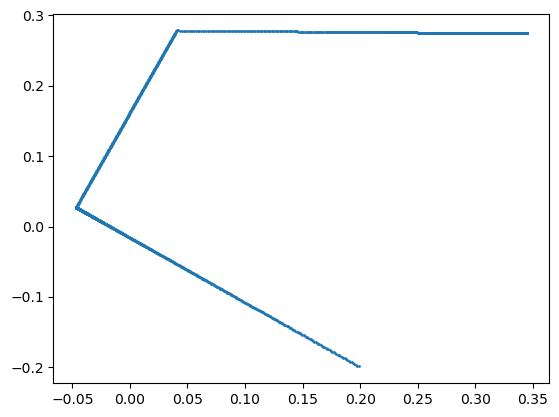

In [ ]:
plt.scatter(all_traj[:,0],all_traj[:,1],s=1)

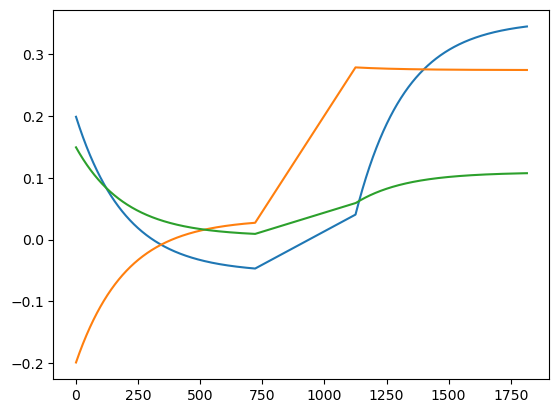

In [ ]:
plt.plot(all_traj[:,:3])

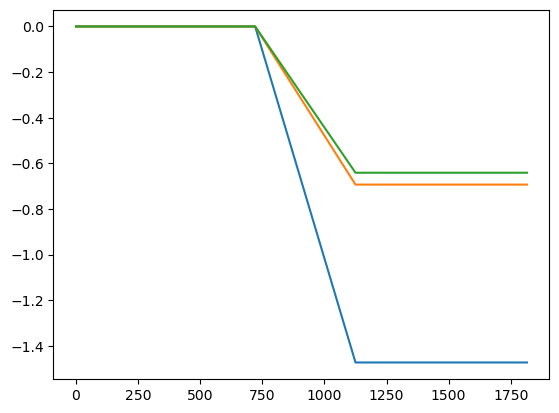

In [ ]:
plt.plot(all_traj[:,3:])

(-0.4, 0.4)

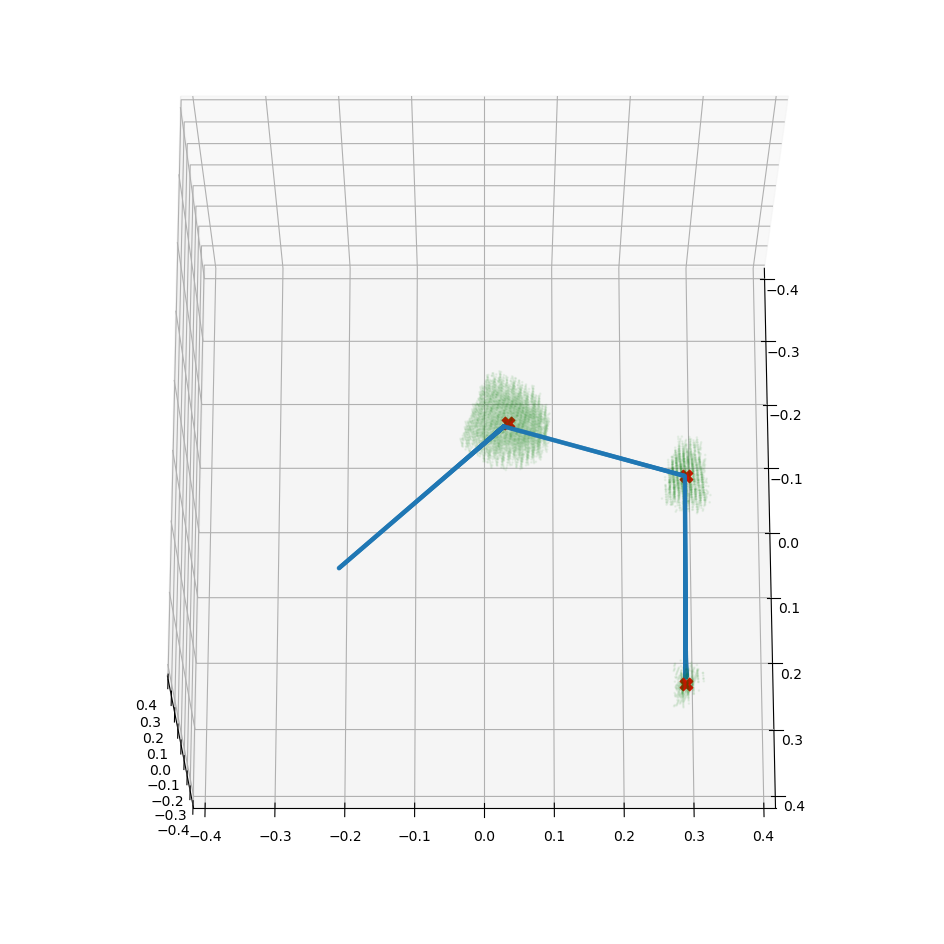

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(inter_points_list)):
    inter_points=inter_points_list[i]
    ax.scatter(inter_points[:,0].detach().cpu(),
               inter_points[:,1].detach().cpu(),
               inter_points[:,2].detach().cpu(),s=1,c='g',alpha=0.05)

    # ax.scatter(xyz_combined[:,0].detach().cpu(),
    #            xyz_combined[:,1].detach().cpu(),
    #            xyz_combined[:,2].detach().cpu(),s=10,c='k')

    mean_inter_p=inter_points.mean(axis=0)

    ax.scatter(mean_inter_p[0].detach().cpu(),
               mean_inter_p[1].detach().cpu(),
               mean_inter_p[2].detach().cpu(),s=80,marker='X',c='r')


ax.scatter(all_traj[:,0],all_traj[:,1],all_traj[:,2],s=5)

ax.view_init(elev=70, azim=-0)
ax.set_xlim(-0.4,0.4)
ax.set_ylim(-0.4,0.4)
ax.set_zlim(-0.4,0.4)

In [ ]:
def generate_cubic_spline_through_points_scipy(points):
    t = np.zeros(points.shape[0])
    for i in range(1, t.shape[0]):
        t[i] = t[i-1] + np.linalg.norm(points[i] - points[i-1])

    cs_x = CubicSpline(t, points[:, 0])
    cs_y = CubicSpline(t, points[:, 1])
    cs_z = CubicSpline(t, points[:, 2])

    return cs_x, cs_y, cs_z, t

def evaluate_cubic_spline_velocity(cs_x, cs_y, cs_z, t):
    vx = cs_x(t, 1)
    vy = cs_y(t, 1)
    vz = cs_z(t, 1)

    return np.column_stack([vx, vy, vz])

In [ ]:
mean_list=[initial_pos]
for i in range(len(inter_points_list)):
    mean_val=torch.mean(inter_points_list[i],dim=0)
    mean_list.append(mean_val.detach().clone())

In [ ]:
mean_pos_tor=torch.vstack(mean_list)

In [ ]:
mean_pos_tor

tensor([[ 0.2000, -0.3000,  0.2500],
        [-0.0650,  0.0068,  0.0985],
        [ 0.0102,  0.2539,  0.1141],
        [ 0.2906,  0.2976,  0.1336]], dtype=torch.float64)

In [ ]:
def generate_cubic_spline_through_points_scipy(points):
    t = np.zeros(points.shape[0])
    for i in range(1, t.shape[0]):
        t[i] = t[i-1] + np.linalg.norm(points[i] - points[i-1])

    cs_x = CubicSpline(t, points[:, 0])
    cs_y = CubicSpline(t, points[:, 1])
    cs_z = CubicSpline(t, points[:, 2])

    return cs_x, cs_y, cs_z, t

def evaluate_cubic_spline_velocity(cs_x, cs_y, cs_z, t):
    vx = cs_x(t, 1)
    vy = cs_y(t, 1)
    vz = cs_z(t, 1)

    return np.column_stack([vx, vy, vz])
def plot_spline_with_velocity(points, spline, velocity, stride=50):
    """
    Plot the spline and velocity vectors.

    :param points: Array of original points.
    :param spline: Array of points on the spline.
    :param velocity: Array of velocity vectors.
    :param stride: The stride for displaying velocity vectors.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the original points
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='red', label='Original Points')

    # Plot the spline
    ax.plot(spline[:, 0], spline[:, 1], spline[:, 2], color='blue', label='Cubic Spline')

    # Plot the velocity vectors
    for i in range(0, len(velocity), stride):
        v = velocity[i]
        p = spline[i]
        ax.quiver(p[0], p[1], p[2], v[0], v[1], v[2], length=0.1, normalize=True)

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.legend()
    ax.view_init(elev=0, azim=0)
    ax.set_xlim(-0.4,0.4)
    ax.set_ylim(-0.4,0.4)
    ax.set_zlim(-0.4,0.4)
    #plt.show()

In [ ]:
%%time
cs_x, cs_y, cs_z, t = generate_cubic_spline_through_points_scipy(mean_pos_tor.detach())


CPU times: user 1.9 ms, sys: 584 µs, total: 2.48 ms
Wall time: 5.47 ms


In [ ]:
t_fine = np.linspace(t[0], t[-1], 500)
velocity = evaluate_cubic_spline_velocity(cs_x, cs_y, cs_z, t_fine)
velocity[:5]  # Show the first 5 velocity vectors as an example

array([[-1.18518802, -0.00665701, -0.78438571],
       [-1.1799653 ,  0.0029653 , -0.77946484],
       [-1.17474319,  0.01254454, -0.77455756],
       [-1.16952169,  0.02208072, -0.76966388],
       [-1.16430079,  0.03157383, -0.7647838 ]])

In [ ]:
# Evaluate spline points
spline_points = np.column_stack([cs_x(t_fine), cs_y(t_fine), cs_z(t_fine)])

# # Plot the spline and velocity
# plot_spline_with_velocity(mean_pos_tor.detach(), spline_points, velocity)


(-0.4, 0.4)

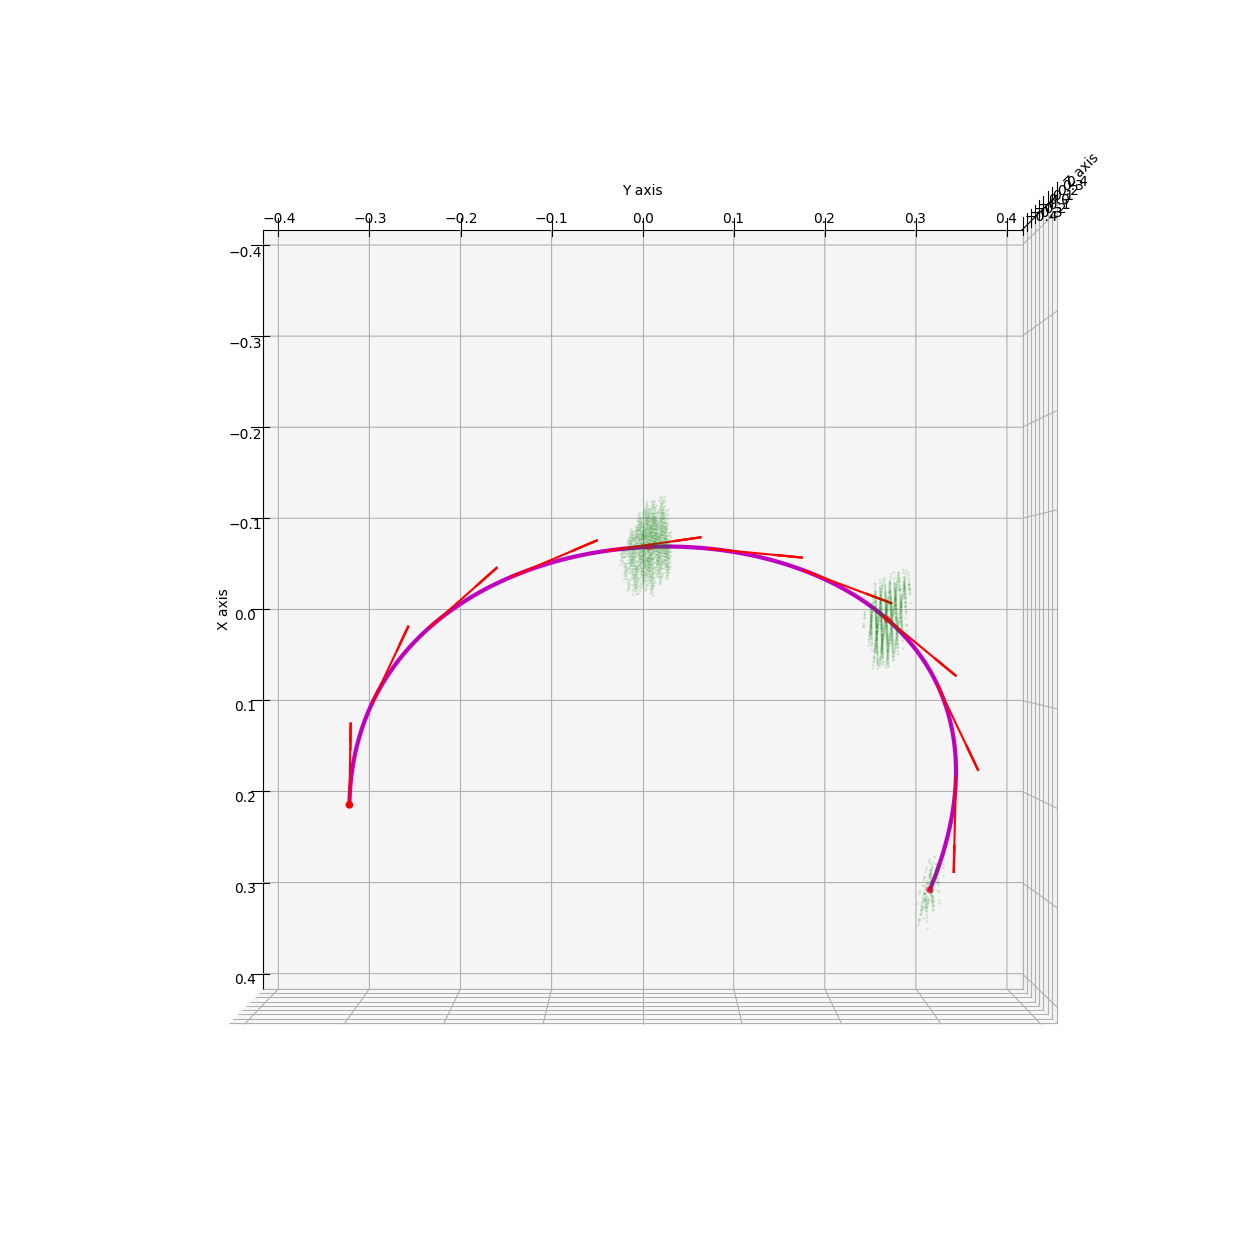

In [ ]:
points = mean_pos_tor.detach()
spline = spline_points
velocity =velocity
stride=50

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d')

# Plot the original points
ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='red', label='Original Points')

# Plot the spline
ax.plot(spline[:, 0], spline[:, 1], spline[:, 2], color='m', label='Cubic Spline',lw=3)

for i in range(len(inter_points_list)):
    inter_points=inter_points_list[i]
    ax.scatter(inter_points[:,0].detach().cpu(),
               inter_points[:,1].detach().cpu(),
               inter_points[:,2].detach().cpu(),s=1,c='g',alpha=0.1)
    
# Plot the velocity vectors
for i in range(0, len(velocity), stride):
    v = velocity[i]
    p = spline[i]
    ax.quiver(p[0], p[1], p[2], v[0], v[1], v[2],color='r', length=0.1, normalize=True)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
#ax.legend()
ax.view_init(elev=90, azim=0)
ax.set_xlim(-0.4,0.4)
ax.set_ylim(-0.4,0.4)
ax.set_zlim(-0.4,0.4)